In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LinearRegression, RANSACRegressor, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', context='notebook')

In [10]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', 
                 header=None, 
                 sep='\s+')
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


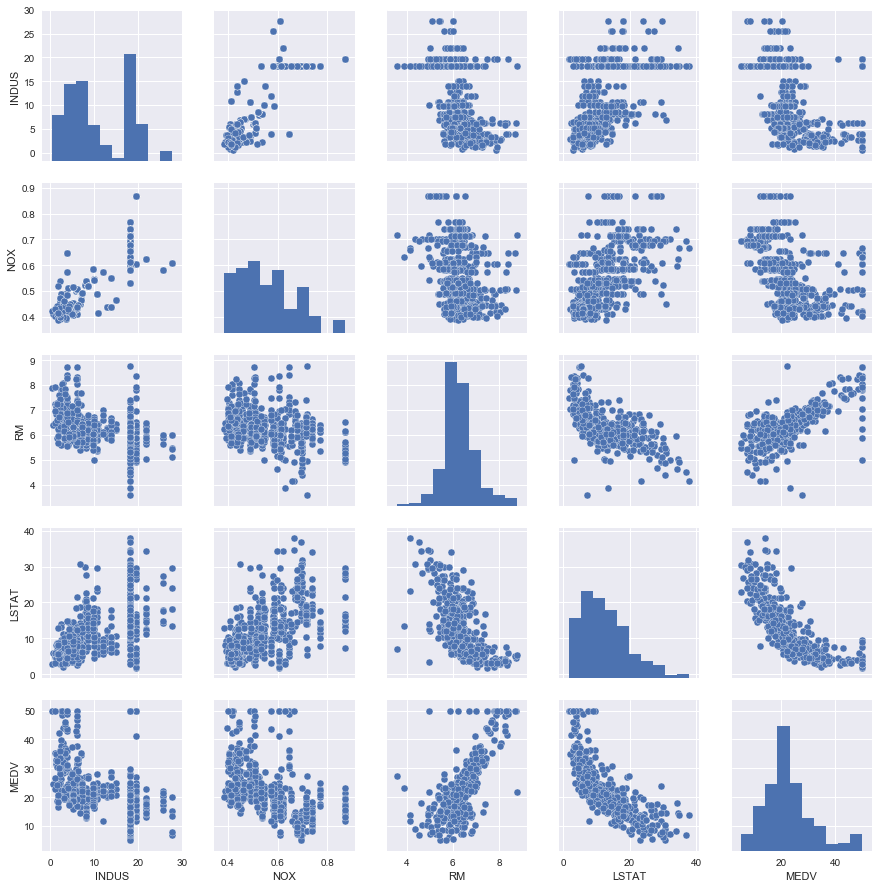

In [13]:
cols = ['INDUS','NOX', 'RM', 'LSTAT', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.show()

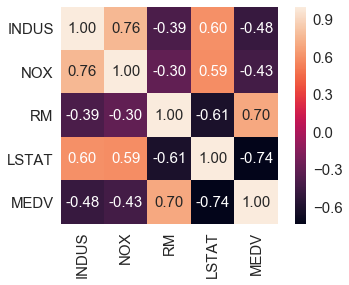

In [15]:
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.show()

# linear gradient descent regression from scratch

In [68]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
        
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0] # calc y under current weights
        
    def fit(self, X, y):
        y = y[:,0]
        self.w_ = np.zeros(1 + X.shape[1]) # initialize weights to zeros
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors) # update weights
            self.w_[0] += self.eta * errors.sum() # update intercept
            cost = (errors**2).sum() # sum of squared errors
            self.cost_.append(cost) # record epoch
            
        return self
    
    def predict(self, X):
        return self.net_input(X)

In [70]:
#test
X = df[['RM']].values
y = df[['MEDV']].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

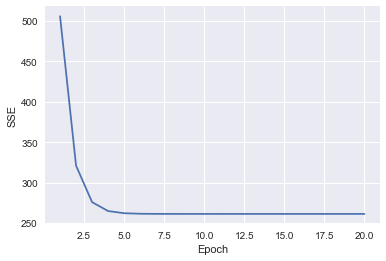

In [71]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [72]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

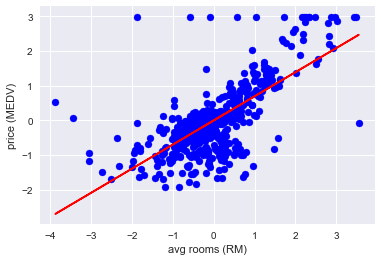

In [73]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('avg rooms (RM)')
plt.ylabel('price (MEDV)')
plt.show()

# using sklearn

In [75]:
slr = LinearRegression()
slr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [76]:
slr.coef_

array([[9.10210898]])

In [77]:
slr.intercept_

array([-34.67062078])

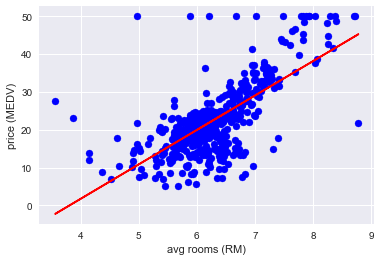

In [78]:
lin_regplot(X, y, slr)
plt.xlabel('avg rooms (RM)')
plt.ylabel('price (MEDV)')
plt.show()

# solving closed-form OLS

In [79]:
# w = (XT * X)-1 * XT * y

Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])

z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

w

array([[-34.67062078],
       [  9.10210898]])

# Robust regression with RANSAC

In [82]:
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                        residual_threshold=5.0,
                        random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x1a190321e0>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

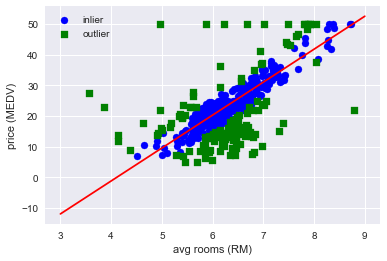

In [85]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
           c='blue', marker='o', label='inlier')
plt.scatter(X[outlier_mask], y[outlier_mask],
           c='green', marker='s', label='outlier')
plt.plot(line_X, line_y_ransac, color='red')
plt.legend(loc='upper left')
plt.xlabel('avg rooms (RM)')
plt.ylabel('price (MEDV)')
plt.show()

In [86]:
ransac.estimator_.coef_

array([[10.73450881]])

In [87]:
ransac.estimator_.intercept_

array([-44.08906429])

# using regularization methods

In [91]:
l1 = Lasso(alpha=1.0)
l2 = Ridge(alpha=1.0)
en = ElasticNet(alpha=1.0, l1_ratio=.5)

# regression w/ decision trees & random forest

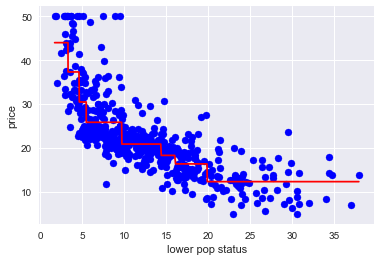

In [97]:
# decision tree
X = df[['LSTAT']].values
y = df[['MEDV']].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)

plt.xlabel('lower pop status')
plt.ylabel('price')
plt.show()

In [98]:
# random forest
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestRegressor(n_estimators=1000,
                          criterion='mse',
                          random_state=1,
                          n_jobs=-1)

rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [99]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [114]:
def print_accuracies(y, pred, split_name):
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    print('''{}
    MSE =\t{:.3f}
    R^2 =\t{:.3f}
    '''.format(split_name, mse, r2))

In [115]:
print_accuracies(y_train, y_train_pred, 'TRAIN')
print_accuracies(y_test, y_test_pred, 'TEST')

TRAIN
    MSE =	1.642
    R^2 =	0.979
    
TEST
    MSE =	11.052
    R^2 =	0.878
    


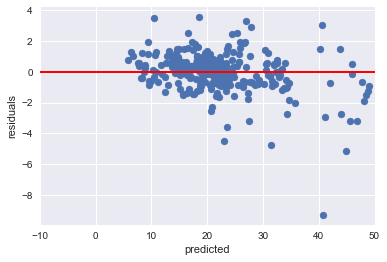

In [116]:
plt.scatter(y_train_pred, y_train_pred - y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()